# Process Historical NOAA LCD weather
This script cleans and formats a manually downloaded "National Oceanic and Atmospheric Administration" (NOAA) "LCD CSV" weather file.  It outputs an hourly, daily and weekly csv of cleaned data. 

This script generates the following output from the NOAA source files:
'DewPointTemperature', 'DryBulbTemperature', 'Precipitation', 'RelativeHumidity', 'SkyConditions',
 'StationPressure', 'Visibility', 'WetBulbTemperature', 'WindDirection', 'WindGustSpeed',
 'WindSpeed'.
 
 Additionally the following features are added to the source data:
 'season', 'weekday', 'Peak Coincident', 'holiday', 'Temperature_DB_bin'
 
https://github.com/emskiphoto/Process-historical-NOAA-LCD-weather<BR>
Copyright 2021 Matt Chmielewski


## Request .csv file from NOAA and save to disk
Select "LCD .csv" option
https://www.ncdc.noaa.gov/cdo-web/datatools/lcd<BR>

#### After selecting weather station, go to 'Cart'
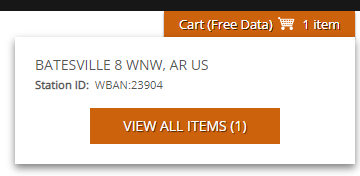

#### In the NOAA Cart, choose 'LCD CSV' for the appropriate date range and submit request.   An email link will be sent to you.
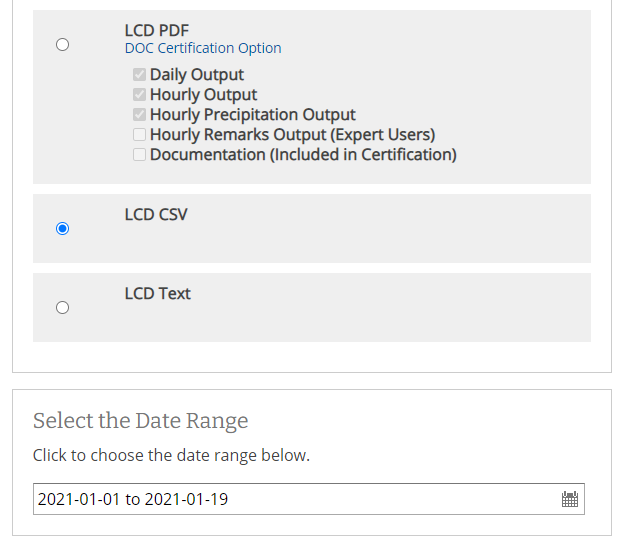

### Load Python packages

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import holidays
from pathlib import PureWindowsPath as PureWindowsPath
# turn off Jedi autocomplete (that was causing more problems than benefits post Win10 update 3-13-2020)
%config Completer.use_jedi = False 

### Load custom functions

In [8]:
def file_path_from_input():
    """Reads pasted Windows file path, Ex. "C:/Downloads/report06357.csv"
    and returns Python-formatted file path.
    Recommended usage:  'file_path = file_path_from_input()'"""
    print("Locate file using Windows Explorer,\nHold Shift & right-click file name,\n"
    "'Copy as Path'\n")
    mydir = input('Paste Windows path to file (Ex. "C:/Downloads/report06357.csv"):  ')
    # format input path as needed
#     file_path = pathlib.PureWindowsPath(mydir).as_posix().replace('"','')
    file_path = PureWindowsPath(mydir).as_posix().replace('"','')
    return file_path

def weather_assign_season(df):
    """Assigns a 'season' column to the df and designates a season name per the 
    dates used in the U.S.A., ex. ['winter', 'spring', 'summer', 'fall']"""
    season_days = {'spring': range(80,171),
                        'summer': range(172,264),
                        'fall': range(265,356),
                        'winter': list(range(357,366)) + list(range(0,79))}
    for season in season_days:
        df.loc[df.index.dayofyear.isin(season_days[season]),'season'] = season
    return df

def is_month_and_hour_in_list(df, new_column='peak_coincident', months=[6,7,8,9],hours=[14,15,16,17]):
    """Adds a 'new_column' with True/False status in the input df if the months and hours of the
    datetime index match the values input for months and hours."""
    df[new_column] = df.index.month.isin(months) & df.index.hour.isin(hours)
    return df

def generate_list_of_holidays(years=[2020], state='MN'):
    """Generates a list of 'Holidays' for list of years and a given state.  Must install
    'holidays' package (from powershell prompt:  pip install)"""
    holidates = []
    for year in years:
        for date, name in sorted(holidays.US(state=state, years=year).items()):
            holidates.append(date)
    return holidates

def weather_clean_NOAA_csv(file, pct_null_replace=2):
    """Returns a cleaned and formatted weather file from hourly NOAA weather data csv's saved locally and
    obtained from https://www.ncdc.noaa.gov/cdo-web/datatools/lcd.  Columns with percentage of null
    data less than pct_null_replace will have null values replaced by estimated values.
    
    Outputs an hourly, daily and weekly frequency csv of cleaned data for the following categories:
    "DewPointTemperature", "DryBulbTemperature", "Precipitation", "RelativeHumidity", "SkyConditions"
    "StationPressure", "Visibility", "WetBulbTemperature", "WindDirection", "WindGustSpeed", "WindSpeed".
    These are just a few of the 120 columns in the file.   
    
    Output file name format is:
    "Station #_first datetime to last datetime_frequency", Ex.  '72565003017_1998-01-01 to 2005-12-31_hourly.csv' 
    The following columns are added to the data: 
    'season'  - Spring, Summer, etc.
    'weekday/weekend' - for hourly and daily dates
    'Peak Coincident' - True/False tag if hourly timestamp is in June, July, August or September between
            14:00 and 18:00 on a weekday
            
    Recommended Usage:
    weather = weather_clean_NOAA_csv("C:/Users/237525/weather/data/CO and MN 1998-2020/2307241.csv")
    
    Additional useful columns from NOAA include 'Sunrise', 'Sunset','CDSD', 'CLDD','HDSD', 'HTDD',
    however they are not on hourly intervals and were not included here"""
#     Load file
    file_path = PureWindowsPath(file).as_posix().replace('"','')
    #     Select desired columns for analysis and define datatypes
    cols_dict = {'HourlyDewPointTemperature': 'float64',
        'HourlyDryBulbTemperature': 'float64',
        'HourlyPrecipitation': 'float64',
        'HourlyRelativeHumidity': 'float64',
        'HourlySkyConditions': 'object',
        'HourlyStationPressure': 'float64',
        'HourlyVisibility': 'object',
        'HourlyWetBulbTemperature': 'float64',
        'HourlyWindDirection': 'Int64',
        'HourlyWindGustSpeed': 'float64',
        'HourlyWindSpeed': 'float64'}
#     open csv and store in pandas dataframe
    df = pd.read_csv(file_path, parse_dates=['DATE'], index_col='DATE', low_memory=False)
#     create timestamps and base file name
    start_date = df.index[0].strftime('%Y-%m-%d')
    end_date = df.index[-1].strftime('%Y-%m-%d')
    station = df.STATION.iloc[0]
    export_file_base = "{}_{} to {}".format(station, start_date, end_date)

#     Locate columns that should have numeric data only and force them to numeric format
    numeric_cols = [key for key in cols_dict.keys() if cols_dict[key] == 'float64' or 'int64']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Reduce df to contain only the columns in cols_dict
    df = df[cols_dict.keys()]
#     For some reason, each record that occurs at the "23:59:00" timestamp is NaN.   Delete these records
    df = df.loc[~((df.index.hour == 23) & (df.index.minute == 59))]
#     Check what percentage of data has null data and print to screen
    null_data_pct_table = pd.DataFrame({'Percent N/A': df.isnull().sum().divide(len(df)).round(3)})
    null_data_pct_table_formatted = null_data_pct_table['Percent N/A'].apply(lambda n: '{:,.1%}'.format(n))
    display(null_data_pct_table_formatted)
#     determine which columns to fill na values based on percent null
    fillna_cols = null_data_pct_table.loc[null_data_pct_table['Percent N/A'] < pct_null_replace/100].index
    df.loc[:,fillna_cols] = df.loc[:,fillna_cols].fillna(method='ffill')
#     Resample data to produce evenly spaced interval data
    df = df.resample('H').median()
#     assign seasons to df in new 'season' column
    df = weather_assign_season(df)
#     assign weekend or weekday tag to each day
    df['weekday'] = 'weekday'
    df.loc[~df.index.weekday.isin(list(range(0,5))),'weekday'] = 'weekend'
    df['weekday'] = df['weekday'].astype('category')   # keep memory size to a minimum
#     Add True/False Peak Coincident column
    df = is_month_and_hour_in_list(df, new_column='Peak Coincident', months=[6,7,8,9],hours=[14,15,16,17])
#     Add holiday True/False:
    years = list(df.index.year.unique())
    try:
        holiday_dates = generate_list_of_holidays(years=years)
        holiday_YMD = []
        for d in holiday_dates:
            holiday_YMD.append(datetime.datetime(d.year, d.month, d.day).date())
        df['holiday'] = [dat in holiday_YMD for dat in df.index.date]
#         alternatively:
# holiday_dates = generate_list_of_holidays(years=df.index.year.unique().to_list())
# df['Date_copy_delete'] = df.index.date.copy()
# df['holiday'] = df.Date_copy_delete.apply(lambda date: date in holiday_dates)
# df.drop(columns=['Date_copy_delete'], inplace=True)
    except:
        print("Holidays were not tagged.  Veritfy it 'Holidays' python package is installed")
#     Add temperature bins
    temp_bins = list(range(-30,110,5))
    df['Temperature_DB_bin'] = pd.cut(df['HourlyDryBulbTemperature'],bins=temp_bins)

    print(file_path)
    return df

In [9]:
file = file_path_from_input()
df = weather_clean_NOAA_csv(file)

Locate file using Windows Explorer,
Hold Shift & right-click file name,
'Copy as Path'

Paste Windows path to file (Ex. "C:/Downloads/report06357.csv"):  "C:\Users\user\OneDrive\Python_373\GitHub\data\Hennepin Climate 1-01-19 to 3-01-2020.csv"


HourlyDewPointTemperature     0.7%
HourlyDryBulbTemperature      0.7%
HourlyPrecipitation          33.5%
HourlyRelativeHumidity        0.7%
HourlySkyConditions          94.1%
HourlyStationPressure         1.6%
HourlyVisibility              0.9%
HourlyWetBulbTemperature      1.6%
HourlyWindDirection           3.4%
HourlyWindGustSpeed          83.0%
HourlyWindSpeed               0.7%
Name: Percent N/A, dtype: object

C:/Users/user/OneDrive/Python_373/GitHub/data/Hennepin Climate 1-01-19 to 3-01-2020.csv


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10202 entries, 2019-01-01 00:00:00 to 2020-03-01 01:00:00
Freq: H
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   HourlyDewPointTemperature  10194 non-null  float64 
 1   HourlyDryBulbTemperature   10194 non-null  float64 
 2   HourlyPrecipitation        9227 non-null   float64 
 3   HourlyRelativeHumidity     10194 non-null  float64 
 4   HourlySkyConditions        911 non-null    float64 
 5   HourlyStationPressure      10194 non-null  float64 
 6   HourlyVisibility           10194 non-null  float64 
 7   HourlyWetBulbTemperature   10194 non-null  float64 
 8   HourlyWindDirection        9949 non-null   float64 
 9   HourlyWindGustSpeed        1867 non-null   float64 
 10  HourlyWindSpeed            10194 non-null  float64 
 11  season                     10106 non-null  object  
 12  weekday                    10202 non-null  ca

#### Create export file 

In [11]:
city = input("Input city or project name:  ")
start_date = df.index[0].strftime( "%Y-%m-%d" )
end_date = df.index[-1].strftime( "%Y-%m-%d" )
export_name = "{}_".format(city) + start_date + "_to_" + end_date + f"_{df.index.freqstr}.csv"
export_name

Input city or project name:  minneapolis


'minneapolis_2019-01-01_to_2020-03-01_H.csv'

In [12]:
# os.path.join(os.path.dirname(file),export_name)

In [15]:
[col.replace('Hourly','') for col in df.columns]

['DewPointTemperature',
 'DryBulbTemperature',
 'Precipitation',
 'RelativeHumidity',
 'SkyConditions',
 'StationPressure',
 'Visibility',
 'WetBulbTemperature',
 'WindDirection',
 'WindGustSpeed',
 'WindSpeed',
 'season',
 'weekday',
 'Peak Coincident',
 'holiday',
 'Temperature_DB_bin']

In [14]:
df.columns

Index(['HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity', 'HourlySkyConditions',
       'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'season', 'weekday', 'Peak Coincident', 'holiday',
       'Temperature_DB_bin'],
      dtype='object')

In [13]:
df.to_csv(os.path.join(os.path.dirname(file),export_name))
# os.path.join(os.path.dirname(directory),f'All_M_V_data {todays_date}.csv')

# END